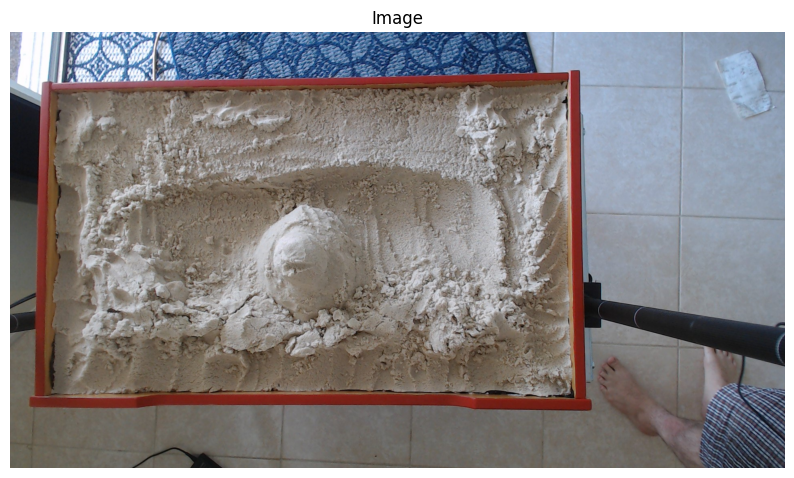

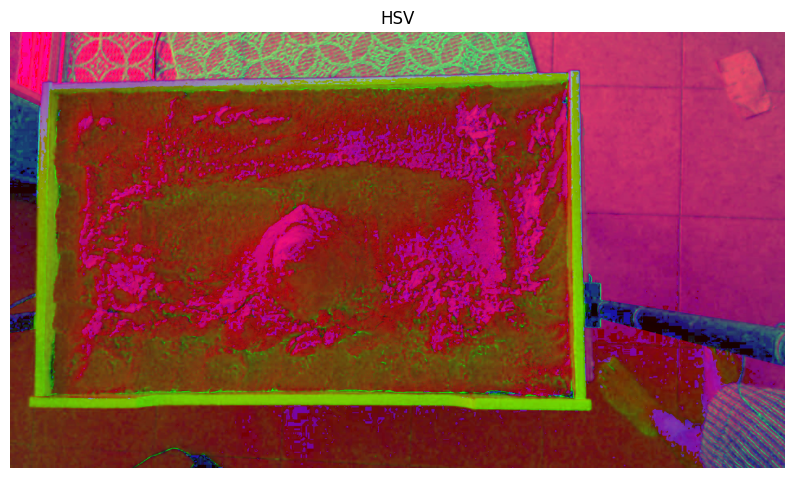

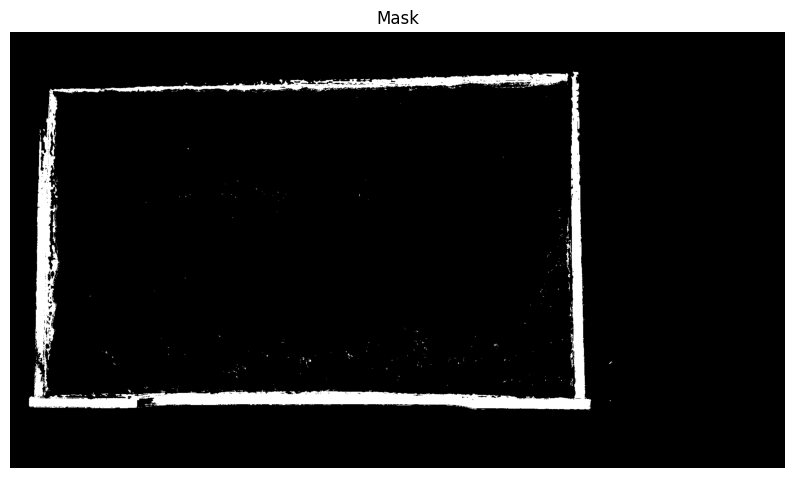

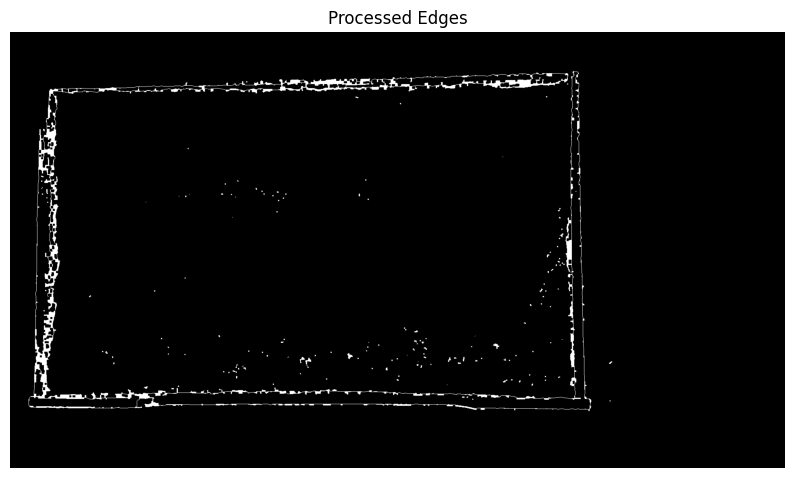

Ordered points:
Point 0: [ 97. 145.]
Point 1: [1407.   99.]
Point 2: [1435.  938.]
Point 3: [ 49. 928.]
Width: 1386, Height: 839


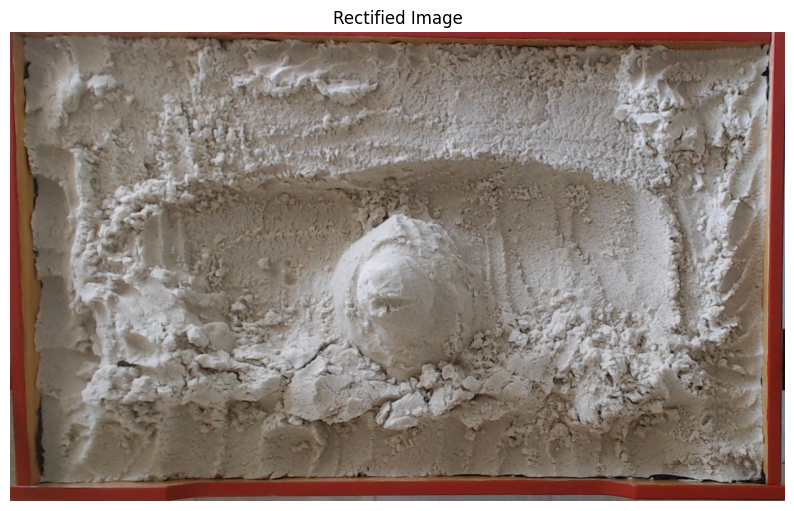

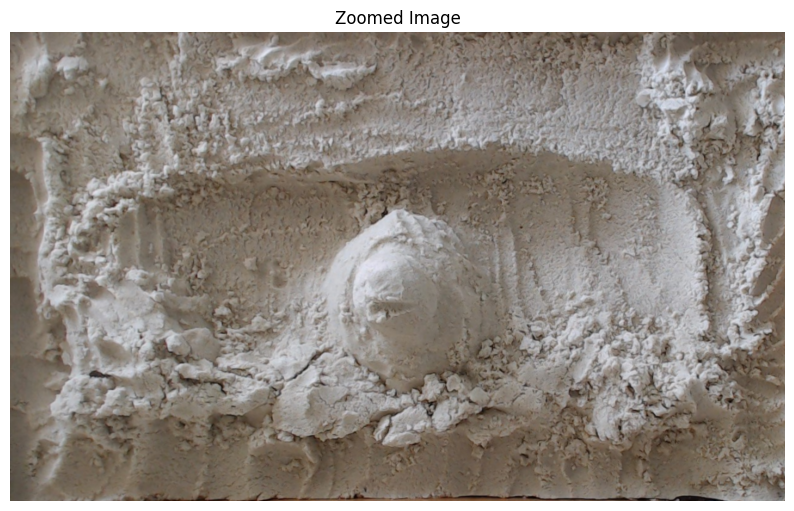

'Downloads/rectified-sand-demo.jpg'

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def zoom_at(img, zoom, coord=None):
    """
    Simple image zooming without boundary checking.
    Centered at "coord", if given, else the image center.

    img: numpy.ndarray of shape (h,w,:)
    zoom: float
    coord: (float, float)
    """
    # Translate to zoomed coordinates
    h, w, _ = [ zoom * i for i in img.shape ]
    
    if coord is None:
        cx, cy = (w - 1) / 2, (h - 1) / 2
    else:
        cx, cy = [ zoom * c for c in coord ]
    
    img = cv2.resize(img, (0, 0), fx=zoom, fy=zoom)
    img = img[int(round(cy - h / zoom * 0.5)) : int(round(cy + h / zoom * 0.5)),
              int(round(cx - w / zoom * 0.5)) : int(round(cx + w / zoom * 0.5)),
              :]
    
    return img

image_path = 'Downloads/sand-2.jpg'
image = cv2.imread(image_path)

plt.figure(figsize=(10, 10))
plt.title('Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(10, 10))
plt.title('HSV')
plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

lower_color = np.array([0, 100, 96])
upper_color = np.array([15, 255, 176])

# Create a mask for the red color
mask = cv2.inRange(hsv, lower_color, upper_color)

plt.figure(figsize=(10, 10))
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

# Canny edge detection
edges = cv2.Canny(mask, 50, 150, apertureSize=3)

kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(10, 10))
plt.title('Processed Edges')
plt.imshow(closed, cmap='gray')
plt.axis('off')
plt.show()

contours, _ = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
hull = cv2.convexHull(largest_contour)

epsilon = 0.02 * cv2.arcLength(hull, True)
approx = cv2.approxPolyDP(hull, epsilon, True)

if len(approx) == 4:
    points = order_points(approx.reshape(4, 2))
    
    print("Ordered points:")
    for i, point in enumerate(points):
        print(f"Point {i}: {point}")

    width = max(int(points[1][0] - points[0][0]), int(points[2][0] - points[3][0]))
    height = max(int(points[3][1] - points[0][1]), int(points[2][1] - points[1][1]))
    
    print(f"Width: {width}, Height: {height}")

    dst_points = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(points, dst_points)
    rectified_image = cv2.warpPerspective(image, M, (width, height))

    output_path = 'Downloads/rectified-sand-demo.jpg'
    cv2.imwrite(output_path, rectified_image)

    plt.figure(figsize=(10, 10))
    plt.title('Rectified Image')
    plt.imshow(cv2.cvtColor(rectified_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    zoom_amount = 1.10
    zoomed_image = zoom_at(rectified_image, zoom_amount)

    zoomed_output_path = 'Downloads/zoomed-sand-demo.jpg'
    cv2.imwrite(zoomed_output_path, zoomed_image)

    plt.figure(figsize=(10, 10))
    plt.title('Zoomed Image')
    plt.imshow(cv2.cvtColor(zoomed_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("Error: The detected contour does not have exactly four points: ")
    print(len(approx))

output_path


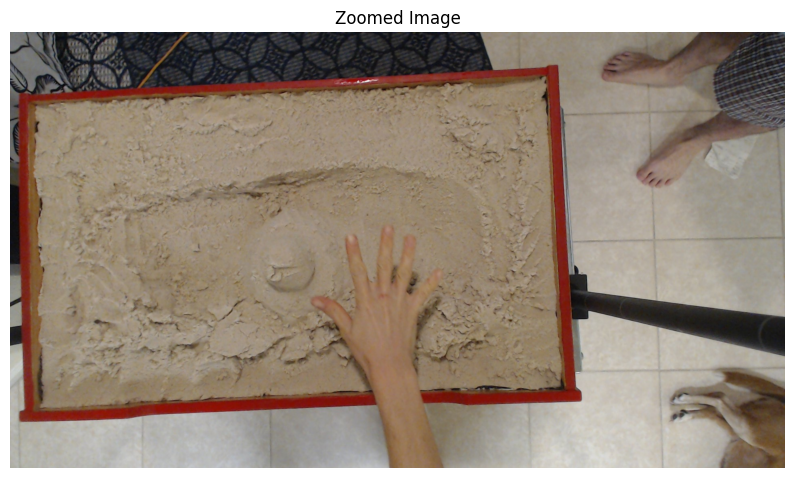

Hands found


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1722413137.831868    4614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722413137.842259    4614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/nineso/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [2]:
import cv2
import mediapipe as mp

image_path = 'Downloads/hand-1.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.title('Zoomed Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

mp_hands = mp.solutions.hands.Hands()

results = mp_hands.process(image_rgb)
if results.multi_hand_landmarks:
    print("Hands found")
else:
    print("No hands found")